In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, col

In [2]:
# Build the SparkSession
spark = SparkSession.builder \
   .master("local") \
   .appName("DDAM Project") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()
   
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/11 10:47:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Import

In [3]:
df_boxscore = spark.read.csv("data/boxscore.csv", header=True, inferSchema=True)
df_games = spark.read.csv("data/games.csv", header=True, inferSchema=True)
df_salaries = spark.read.csv("data/salaries.csv", header=True, inferSchema=True)
df_playerInfo = spark.read.csv("data/player_info.csv", header=True, inferSchema=True)

In [4]:
print(df_boxscore.count(), df_games.count(), df_salaries.count(), df_playerInfo.count())

741569 30250 11583 5018


In [5]:
df_boxscore.show(5)

+-------+----------------+------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|game_id|        teamName|        playerName|   MP| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|
+-------+----------------+------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|      1|Sacramento Kings|Corliss Williamson|37:20|  7| 11|  0|  0|  0|  0|  1|  3|  4|  4|  1|  1|  4|  5| 14| -2|        1|
|      1|Sacramento Kings|    Mitch Richmond|32:00|  6| 12|  1|  4|  1|  1|  0|  5|  5|  3|  1|  2|  3|  1| 14|-12|        1|
|      1|Sacramento Kings|    Olden Polynice|31:34|  0|  4|  0|  0|  1|  4|  2|  5|  7|  3|  1|  0|  4|  3|  1|-12|        1|
|      1|Sacramento Kings|Mahmoud Abdul-Rauf|29:27|  7| 13|  1|  2|  2|  2|  0|  2|  2|  5|  1|  1|  2|  2| 17| -7|        1|
|      1|Sacramento Kings|       Brian Grant|25:13|  3| 11|  0|  0|  2|  2|  1|  5|  6|  0|  0|  2|  1|  2|  8| -7|   

In [6]:
df_games.show(5)

+---------------+--------------------+----------+--------------------+----------+----------+-----+-------+----------+---------+-------+
|seasonStartYear|            awayTeam|pointsAway|            homeTeam|pointsHome|attendance|notes|startET|  datetime|isRegular|game_id|
+---------------+--------------------+----------+--------------------+----------+----------+-----+-------+----------+---------+-------+
|           1996|    Sacramento Kings|        85|     Houston Rockets|        96|   16285.0| NULL|   NULL|1996-11-01|        1|      1|
|           1996|Los Angeles Clippers|        97|Golden State Warr...|        85|   15593.0| NULL|   NULL|1996-11-01|        1|      2|
|           1996|Portland Trail Bl...|       114| Vancouver Grizzlies|        85|   19193.0| NULL|   NULL|1996-11-01|        1|      3|
|           1996| Seattle SuperSonics|        91|           Utah Jazz|        99|   19911.0| NULL|   NULL|1996-11-01|        1|      4|
|           1996|     New York Knicks|       107

In [7]:
df_salaries.show(5)

+----------------+---------------+-----------+------------------+
|      playerName|seasonStartYear|     salary|inflationAdjSalary|
+----------------+---------------+-----------+------------------+
|  Michael Jordan|           1996|$30,140,000|       $52,258,566|
|    Horace Grant|           1996|$14,857,000|       $25,759,971|
|   Reggie Miller|           1996|$11,250,000|       $19,505,934|
|Shaquille O'Neal|           1996|$10,714,000|       $18,576,585|
|     Gary Payton|           1996|$10,212,000|       $17,706,187|
+----------------+---------------+-----------+------------------+
only showing top 5 rows



In [8]:
df_playerInfo.show(5)

+--------------------+----+----+---+----+-----+----------------+--------------------+
|          playerName|From|  To|Pos|  Ht|   Wt|       birthDate|            Colleges|
+--------------------+----+----+---+----+-----+----------------+--------------------+
|      Alaa Abdelnaby|1991|1995|F-C|6-10|240.0|   June 24, 1968|                Duke|
|     Zaid Abdul-Aziz|1969|1978|C-F| 6-9|235.0|   April 7, 1946|          Iowa State|
|Kareem Abdul-Jabbar*|1970|1989|  C| 7-2|225.0|  April 16, 1947|                UCLA|
|  Mahmoud Abdul-Rauf|1991|2001|  G| 6-1|162.0|   March 9, 1969|                 LSU|
|   Tariq Abdul-Wahad|1998|2003|  F| 6-6|223.0|November 3, 1974|Michigan, San Jos...|
+--------------------+----+----+---+----+-----+----------------+--------------------+
only showing top 5 rows



# removing columns and dates

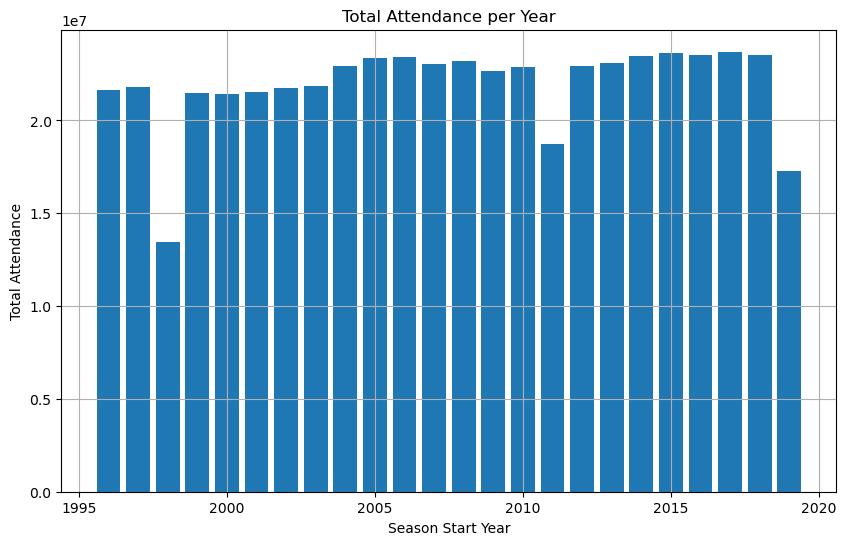

In [9]:
from pyspark.sql.functions import sum
import matplotlib.pyplot as plt

df_sum = df_games.groupBy("seasonStartYear").agg(sum("attendance").alias("total_attendance"))

# Convert Spark DataFrame to Pandas DataFrame
pandas_df_sum = df_sum.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(pandas_df_sum["seasonStartYear"], pandas_df_sum["total_attendance"])
plt.title("Total Attendance per Year")
plt.xlabel("Season Start Year")
plt.ylabel("Total Attendance")
plt.grid(True)
plt.show()

In [10]:
#removing notes and startET from df_games
columns_to_drop = ["awayTeam", "pointsAway", "homeTeam", "pointsHome", "attendance", "notes", "startET", "datetime"]

# Drop the specified columns
df_games = df_games.drop(*columns_to_drop)

# Show the first 5 rows of the updated df_games DataFrame
df_games.show(5)

+---------------+---------+-------+
|seasonStartYear|isRegular|game_id|
+---------------+---------+-------+
|           1996|        1|      1|
|           1996|        1|      2|
|           1996|        1|      3|
|           1996|        1|      4|
|           1996|        1|      5|
+---------------+---------+-------+
only showing top 5 rows



In [11]:
df_games = df_games.filter((col("seasonStartYear") != 1998) & (col("seasonStartYear") != 2011) & (col("seasonStartYear") != 2019))
df_games.show(5)

+---------------+---------+-------+
|seasonStartYear|isRegular|game_id|
+---------------+---------+-------+
|           1996|        1|      1|
|           1996|        1|      2|
|           1996|        1|      3|
|           1996|        1|      4|
|           1996|        1|      5|
+---------------+---------+-------+
only showing top 5 rows



In [12]:
df_salaries = df_salaries.filter((col("seasonStartYear") != 1998) & (col("seasonStartYear") != 2011) & (col("seasonStartYear") != 2019))
df_salaries.show(5)

+----------------+---------------+-----------+------------------+
|      playerName|seasonStartYear|     salary|inflationAdjSalary|
+----------------+---------------+-----------+------------------+
|  Michael Jordan|           1996|$30,140,000|       $52,258,566|
|    Horace Grant|           1996|$14,857,000|       $25,759,971|
|   Reggie Miller|           1996|$11,250,000|       $19,505,934|
|Shaquille O'Neal|           1996|$10,714,000|       $18,576,585|
|     Gary Payton|           1996|$10,212,000|       $17,706,187|
+----------------+---------------+-----------+------------------+
only showing top 5 rows



In [13]:
#game_id that are played between 2000 and 2010
selected_game_ids = df_games.select("game_id").distinct()

#filter salaries based on game_id

df_boxscore = df_boxscore.join(selected_game_ids, "game_id")

df_boxscore.show(5)

+-------+----------------+------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|game_id|        teamName|        playerName|   MP| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|
+-------+----------------+------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|      1|Sacramento Kings|Corliss Williamson|37:20|  7| 11|  0|  0|  0|  0|  1|  3|  4|  4|  1|  1|  4|  5| 14| -2|        1|
|      1|Sacramento Kings|    Mitch Richmond|32:00|  6| 12|  1|  4|  1|  1|  0|  5|  5|  3|  1|  2|  3|  1| 14|-12|        1|
|      1|Sacramento Kings|    Olden Polynice|31:34|  0|  4|  0|  0|  1|  4|  2|  5|  7|  3|  1|  0|  4|  3|  1|-12|        1|
|      1|Sacramento Kings|Mahmoud Abdul-Rauf|29:27|  7| 13|  1|  2|  2|  2|  0|  2|  2|  5|  1|  1|  2|  2| 17| -7|        1|
|      1|Sacramento Kings|       Brian Grant|25:13|  3| 11|  0|  0|  2|  2|  1|  5|  6|  0|  0|  2|  1|  2|  8| -7|   

In [14]:
"""df_playerInfo = df_playerInfo.withColumn("From", df_playerInfo["From"].cast("int"))
df_playerInfo = df_playerInfo.withColumn("To", df_playerInfo["To"].cast("int"))

# Filter rows where the player played between 2000 and 2010
df_playerInfo = df_playerInfo.filter((col("From") >= 2000) & (col("To") <= 2010))

# Show the resulting DataFrame
df_playerInfo.show()"""

'df_playerInfo = df_playerInfo.withColumn("From", df_playerInfo["From"].cast("int"))\ndf_playerInfo = df_playerInfo.withColumn("To", df_playerInfo["To"].cast("int"))\n\n# Filter rows where the player played between 2000 and 2010\ndf_playerInfo = df_playerInfo.filter((col("From") >= 2000) & (col("To") <= 2010))\n\n# Show the resulting DataFrame\ndf_playerInfo.show()'

In [15]:
#for the moment, in df_playerInfo we will not drop the rows that contains player that did not played in between 2000-2010
#because we will do it later with a join

#removing notes and startET from df_games
columns_to_drop = ["From", "To", "birthDate", "Colleges"]

# Drop the specified columns
df_playerInfo = df_playerInfo.drop(*columns_to_drop)

# Show the first 5 rows of the updated df_games DataFrame
df_playerInfo.show(5)

+--------------------+---+----+-----+
|          playerName|Pos|  Ht|   Wt|
+--------------------+---+----+-----+
|      Alaa Abdelnaby|F-C|6-10|240.0|
|     Zaid Abdul-Aziz|C-F| 6-9|235.0|
|Kareem Abdul-Jabbar*|  C| 7-2|225.0|
|  Mahmoud Abdul-Rauf|  G| 6-1|162.0|
|   Tariq Abdul-Wahad|  F| 6-6|223.0|
+--------------------+---+----+-----+
only showing top 5 rows



In [16]:
print(df_boxscore.count(), df_games.count(), df_salaries.count(), df_playerInfo.count())

666021 27242 10179 5018


# Missing values

In [17]:
from pyspark.sql.functions import col,isnan, when, count
df_boxscore.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_boxscore.columns]
   ).show()

+-------+--------+----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|game_id|teamName|playerName| MP| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|
+-------+--------+----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|      0|       0|         0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0| 87|        0|
+-------+--------+----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+



In [18]:
#visualize the rows with +/- equal to NULL
rows_with_null = df_boxscore.filter(
    (col("+/-").isNull()))

rows_with_null.show()


+-------+--------------------+-----------------+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---------+
|game_id|            teamName|       playerName|  MP| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS| +/-|isStarter|
+-------+--------------------+-----------------+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---------+
|    253| Cleveland Cavaliers|   Donny Marshall|0:01|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|NULL|        0|
|    334|      Denver Nuggets|    Melvin Booker|0:28|  1|  1|  1|  1|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  3|NULL|        0|
|    350|      Denver Nuggets|    Melvin Booker|0:52|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|NULL|        0|
|    353|     New York Knicks|     Scott Brooks|0:04|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|NULL|        0|
|    357|    Sacramento Kings|  Kevin Salvadori|0:00|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|

In [19]:
#visualize the rows with +/- equal to 0
filtered_rows = df_boxscore.filter(col("+/-") == "0")

filtered_rows.show(20)


+-------+--------------------+----------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|game_id|            teamName|      playerName|   MP| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|
+-------+--------------------+----------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|      1|     Houston Rockets|    Matt Bullard|13:38|  3|  5|  2|  3|  0|  0|  0|  2|  2|  2|  2|  0|  1|  0|  8|  0|        0|
|      4| Seattle SuperSonics|  Hersey Hawkins|31:35|  1|  3|  0|  2|  3|  4|  1|  4|  5|  1|  0|  0|  0|  1|  5|  0|        1|
|      4|           Utah Jazz|    Chris Morris| 8:03|  0|  3|  0|  3|  0|  0|  0|  3|  3|  0|  0|  0|  0|  1|  0|  0|        0|
|      5|     New York Knicks|   Larry Johnson|28:37|  4|  5|  0|  0|  4|  6|  1|  2|  3|  3|  1|  0|  4|  6| 12|  0|        1|
|      5|     New York Knicks|    Scott Brooks| 6:03|  0|  0|  0|  0|  0|  0|  0|  1|  1|  2|  2|  0|  2

In [20]:
#remove the columns with nulls
df_boxscore = df_boxscore.filter(col("+/-").isNotNull())

In [21]:
from pyspark.sql.functions import col,isnan, when, count
df_boxscore.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_boxscore.columns]
   ).show()

+-------+--------+----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|game_id|teamName|playerName| MP| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|
+-------+--------+----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+
|      0|       0|         0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|        0|
+-------+--------+----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+



In [22]:
from pyspark.sql.functions import col,isnan, when, count
df_salaries.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_salaries.columns]
   ).show()

+----------+---------------+------+------------------+
|playerName|seasonStartYear|salary|inflationAdjSalary|
+----------+---------------+------+------------------+
|         0|              0|     0|                 0|
+----------+---------------+------+------------------+



In [23]:
# Create a list comprehension to count null or NaN values for each column
counts_expr = [count(when(col(c).isNull(), c)).alias(c) if c != 'datetime' else count(when(col(c).isNull(), c)).alias(c+'_null_count') for c in df_games.columns]

# Apply the counts expression to the DataFrame
df_games.select(counts_expr).show()

+---------------+---------+-------+
|seasonStartYear|isRegular|game_id|
+---------------+---------+-------+
|              0|        0|      0|
+---------------+---------+-------+



In [24]:
from pyspark.sql.functions import col,isnan, when, count
df_playerInfo.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_playerInfo.columns]
   ).show()

+----------+---+---+---+
|playerName|Pos| Ht| Wt|
+----------+---+---+---+
|         0|  0|  0|  5|
+----------+---+---+---+



In [25]:
print(df_boxscore.count(), df_games.count(), df_salaries.count(), df_playerInfo.count())

665934 27242 10179 5018


## Joins

In [26]:
#join boxscore and games (for the insertion of the data and the isRegular)
df_boxscore = df_boxscore.join(df_games, "game_id")
df_boxscore.show(20)

+-------+----------------+------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+
|game_id|        teamName|        playerName|   MP| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|seasonStartYear|isRegular|
+-------+----------------+------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+
|      1|Sacramento Kings|Corliss Williamson|37:20|  7| 11|  0|  0|  0|  0|  1|  3|  4|  4|  1|  1|  4|  5| 14| -2|        1|           1996|        1|
|      1|Sacramento Kings|    Mitch Richmond|32:00|  6| 12|  1|  4|  1|  1|  0|  5|  5|  3|  1|  2|  3|  1| 14|-12|        1|           1996|        1|
|      1|Sacramento Kings|    Olden Polynice|31:34|  0|  4|  0|  0|  1|  4|  2|  5|  7|  3|  1|  0|  4|  3|  1|-12|        1|           1996|        1|
|      1|Sacramento Kings|Mahmoud Abdul-Rauf|29:27|  7| 13|  1|  2|  2|  2|  0|  2|  2| 

In [27]:
#join boxscore and player_info (for the insertion of the Position, Ht and Wt)
df_boxscore = df_boxscore.join(df_playerInfo, "playerName")
df_boxscore.show(20)

23/12/11 10:50:53 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------------+-------+--------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+---+----+-----+
|        playerName|game_id|            teamName|   MP| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|seasonStartYear|isRegular|Pos|  Ht|   Wt|
+------------------+-------+--------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+---+----+-----+
|Corliss Williamson|      1|    Sacramento Kings|37:20|  7| 11|  0|  0|  0|  0|  1|  3|  4|  4|  1|  1|  4|  5| 14| -2|        1|           1996|        1|  F| 6-7|245.0|
|    Olden Polynice|      1|    Sacramento Kings|31:34|  0|  4|  0|  0|  1|  4|  2|  5|  7|  3|  1|  0|  4|  3|  1|-12|        1|           1996|        1|C-F|6-11|220.0|
|Mahmoud Abdul-Rauf|      1|    Sacramento Kings|29:27|  7| 13|  1|  2|  2|  2|  0|  2|  2|  5|  1|  1|  2|  2| 17| -7|        1|           1996|

In [28]:
player_occurrences = df_boxscore.groupBy("playerName").count()

# Show the result
player_occurrences.show()

+----------------+-----+
|      playerName|count|
+----------------+-----+
|     Terry Mills|  273|
|   Kosta Perović|   23|
|  Rodney Stuckey|  668|
| Al-Farouq Aminu|  664|
|   Greg Stiemsma|  228|
|  Brandon Ingram|  202|
|     Tyler Lydon|   64|
|  Svi Mykhailiuk|   60|
|Lonnie Walker IV|   36|
|   Michael Smith|  524|
|Shandon Anderson|  785|
|    Carl Herrera|  165|
|   Eric Williams|  676|
|    Bobby Phills|  183|
|   Lloyd Daniels|   39|
|  Terry Cummings|  171|
|  Ledell Eackles|   67|
|    Andre Miller| 1371|
|      Lee Nailon|  405|
|  Marcus Haislip|  206|
+----------------+-----+
only showing top 20 rows



In [29]:
#output_path = "data/df_boxscore_2000-2010"
#df_boxscore.write.csv(output_path, header=True, mode="overwrite")

In [30]:
print(df_boxscore.count(), df_salaries.count())

646071 10179


# managing data types

In [31]:
df_boxscore.printSchema()

root
 |-- playerName: string (nullable = true)
 |-- game_id: integer (nullable = true)
 |-- teamName: string (nullable = true)
 |-- MP: string (nullable = true)
 |-- FG: string (nullable = true)
 |-- FGA: string (nullable = true)
 |-- 3P: string (nullable = true)
 |-- 3PA: string (nullable = true)
 |-- FT: string (nullable = true)
 |-- FTA: string (nullable = true)
 |-- ORB: string (nullable = true)
 |-- DRB: string (nullable = true)
 |-- TRB: string (nullable = true)
 |-- AST: string (nullable = true)
 |-- STL: string (nullable = true)
 |-- BLK: string (nullable = true)
 |-- TOV: string (nullable = true)
 |-- PF: string (nullable = true)
 |-- PTS: string (nullable = true)
 |-- +/-: string (nullable = true)
 |-- isStarter: integer (nullable = true)
 |-- seasonStartYear: integer (nullable = true)
 |-- isRegular: integer (nullable = true)
 |-- Pos: string (nullable = true)
 |-- Ht: string (nullable = true)
 |-- Wt: double (nullable = true)



In [32]:
# Assuming df_boxscore is your DataFrame
columns_to_check = ["FG", "FGA", "3P", "3PA", "FT", "FTA", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS", "+/-"]

# Convert the specified columns to integers, and filter out the rows where the conversion fails
converted_df = df_boxscore.select(
    "*",
    *[col(c).cast("int").isNotNull().alias(c+"_is_int") for c in columns_to_check]
)

# Show the rows where conversion to integer failed
failed_conversion_rows = converted_df.filter(~col("FG_is_int") | ~col("FGA_is_int") |
                                              ~col("3P_is_int") | ~col("3PA_is_int") | ~col("FT_is_int") |
                                              ~col("FTA_is_int") | ~col("ORB_is_int") | ~col("DRB_is_int") |
                                              ~col("TRB_is_int") | ~col("AST_is_int") | ~col("STL_is_int") |
                                              ~col("BLK_is_int") | ~col("TOV_is_int") | ~col("PF_is_int") |
                                              ~col("PTS_is_int") | ~col("+/-_is_int"))

# Count the rows where conversion to integer failed
failed_conversion_count = failed_conversion_rows.count()

# Display the count and the first few rows where the conversion to integer failed
print("Number of rows with non-convertible string values:", failed_conversion_count)



Number of rows with non-convertible string values: 106900


In [33]:

# Assuming df_boxscore is your DataFrame
columns_to_convert = ["FG", "FGA", "3P", "3PA", "FT", "FTA", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS", "+/-"]

# Convert the specified columns to integers and drop rows where conversion is not possible
for column in columns_to_convert:
    df_boxscore = df_boxscore.withColumn(column, col(column).cast("int"))

# Drop rows where any of the specified columns is null after conversion
df_boxscore = df_boxscore.dropna(subset=columns_to_convert)

# Show the first few rows after conversion and removal of rows with non-convertible values
df_boxscore.show(20)


+------------------+-------+--------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+---+----+-----+
|        playerName|game_id|            teamName|   MP| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|seasonStartYear|isRegular|Pos|  Ht|   Wt|
+------------------+-------+--------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+---+----+-----+
|Corliss Williamson|      1|    Sacramento Kings|37:20|  7| 11|  0|  0|  0|  0|  1|  3|  4|  4|  1|  1|  4|  5| 14| -2|        1|           1996|        1|  F| 6-7|245.0|
|    Olden Polynice|      1|    Sacramento Kings|31:34|  0|  4|  0|  0|  1|  4|  2|  5|  7|  3|  1|  0|  4|  3|  1|-12|        1|           1996|        1|C-F|6-11|220.0|
|Mahmoud Abdul-Rauf|      1|    Sacramento Kings|29:27|  7| 13|  1|  2|  2|  2|  0|  2|  2|  5|  1|  1|  2|  2| 17| -7|        1|           1996|

In [34]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

# Assuming df_boxscore is your DataFrame
def convert_to_seconds(time_str):
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds

# Create a user-defined function (UDF) for the conversion
convert_to_seconds_udf = udf(convert_to_seconds, IntegerType())

# Apply the UDF to the "MP" column and create a new "MP_seconds" column
df_boxscore = df_boxscore.withColumn("MP_seconds", convert_to_seconds_udf(col("MP")))

# Show the DataFrame with the new "MP_seconds" column
df_boxscore.show(20)


+------------------+-------+--------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+---+----+-----+----------+
|        playerName|game_id|            teamName|   MP| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|seasonStartYear|isRegular|Pos|  Ht|   Wt|MP_seconds|
+------------------+-------+--------------------+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+---+----+-----+----------+
|Corliss Williamson|      1|    Sacramento Kings|37:20|  7| 11|  0|  0|  0|  0|  1|  3|  4|  4|  1|  1|  4|  5| 14| -2|        1|           1996|        1|  F| 6-7|245.0|      2240|
|    Olden Polynice|      1|    Sacramento Kings|31:34|  0|  4|  0|  0|  1|  4|  2|  5|  7|  3|  1|  0|  4|  3|  1|-12|        1|           1996|        1|C-F|6-11|220.0|      1894|
|Mahmoud Abdul-Rauf|      1|    Sacramento Kings|29:27|  7| 13|  1|  2|  2|  2|  0|  2|  2

In [35]:
#removing notes and startET from df_games
columns_to_drop = ["MP"]

# Drop the specified columns
df_boxscore = df_boxscore.drop(*columns_to_drop)

# Show the first 5 rows of the updated df_games DataFrame
df_boxscore.show(5)

+------------------+-------+----------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+---+----+-----+----------+
|        playerName|game_id|        teamName| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|seasonStartYear|isRegular|Pos|  Ht|   Wt|MP_seconds|
+------------------+-------+----------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+---+----+-----+----------+
|Corliss Williamson|      1|Sacramento Kings|  7| 11|  0|  0|  0|  0|  1|  3|  4|  4|  1|  1|  4|  5| 14| -2|        1|           1996|        1|  F| 6-7|245.0|      2240|
|    Olden Polynice|      1|Sacramento Kings|  0|  4|  0|  0|  1|  4|  2|  5|  7|  3|  1|  0|  4|  3|  1|-12|        1|           1996|        1|C-F|6-11|220.0|      1894|
|Mahmoud Abdul-Rauf|      1|Sacramento Kings|  7| 13|  1|  2|  2|  2|  0|  2|  2|  5|  1|  1|  2|  2| 17| -7|        1|           1996|     

In [36]:
from pyspark.sql.functions import col,isnan, when, count
df_boxscore.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_boxscore.columns]
   ).show()

+----------+-------+--------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+---+---+---+----------+
|playerName|game_id|teamName| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|seasonStartYear|isRegular|Pos| Ht| Wt|MP_seconds|
+----------+-------+--------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+---+---+---+----------+
|         0|      0|       0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|        0|              0|        0|  0|  0|  0|         0|
+----------+-------+--------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+---+---+---+----------+



In [37]:
df_boxscore.printSchema()

root
 |-- playerName: string (nullable = true)
 |-- game_id: integer (nullable = true)
 |-- teamName: string (nullable = true)
 |-- FG: integer (nullable = true)
 |-- FGA: integer (nullable = true)
 |-- 3P: integer (nullable = true)
 |-- 3PA: integer (nullable = true)
 |-- FT: integer (nullable = true)
 |-- FTA: integer (nullable = true)
 |-- ORB: integer (nullable = true)
 |-- DRB: integer (nullable = true)
 |-- TRB: integer (nullable = true)
 |-- AST: integer (nullable = true)
 |-- STL: integer (nullable = true)
 |-- BLK: integer (nullable = true)
 |-- TOV: integer (nullable = true)
 |-- PF: integer (nullable = true)
 |-- PTS: integer (nullable = true)
 |-- +/-: integer (nullable = true)
 |-- isStarter: integer (nullable = true)
 |-- seasonStartYear: integer (nullable = true)
 |-- isRegular: integer (nullable = true)
 |-- Pos: string (nullable = true)
 |-- Ht: string (nullable = true)
 |-- Wt: double (nullable = true)
 |-- MP_seconds: integer (nullable = true)



In [38]:
print(df_boxscore.count(), df_salaries.count())

539171 10179


In [39]:
# Role cleaning and pre-processing
from pyspark.sql.functions import split, element_at

# Split the "name" column by space and select the first element
df_boxscore = df_boxscore.withColumn("pos_clean", element_at(split(df_boxscore["Pos"], "-"), 1))

# Show the updated DataFrame
df_boxscore.show()

+------------------+-------+--------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+---+----+-----+----------+---------+
|        playerName|game_id|            teamName| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|seasonStartYear|isRegular|Pos|  Ht|   Wt|MP_seconds|pos_clean|
+------------------+-------+--------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+---+----+-----+----------+---------+
|Corliss Williamson|      1|    Sacramento Kings|  7| 11|  0|  0|  0|  0|  1|  3|  4|  4|  1|  1|  4|  5| 14| -2|        1|           1996|        1|  F| 6-7|245.0|      2240|        F|
|    Olden Polynice|      1|    Sacramento Kings|  0|  4|  0|  0|  1|  4|  2|  5|  7|  3|  1|  0|  4|  3|  1|-12|        1|           1996|        1|C-F|6-11|220.0|      1894|        C|
|Mahmoud Abdul-Rauf|      1|    Sacramento Kings|  7| 13|  1|  2|  2| 

In [40]:
# Drop the "age" column
df_boxscore = df_boxscore.drop("Pos")

# FEATURE ENGINEERING 

In [41]:
"""The way this stat helps to see the efficiency 
of a player is that it combines all 
the shots including free-throws, and gives a 
complete picture of how often a player scores. """


# Compute a new column True Shoot Percentage TSP
df_boxscore = df_boxscore.withColumn("TSP", when((2*(col("FGA")+(0.44*col("FTA")))) != 0, col("PTS")/(2*(col("FGA")+(0.44*col("FTA"))))).otherwise(0))


"""  effective field goal percentage shows how efficient the scorer is based on
the fact that perimeter shots are worth three points in fact this stats gi"""

# Compute a new column Effective Field Goal percentage EFG
df_boxscore = df_boxscore.withColumn("EFG", when(col("FGA") != 0, (col("FG")+(0.5*col("3P")))/col("FGA")).otherwise(0))



"""TO Ratio is the number of turnovers a player or team averages per 100 possessions used.
Highlights good scorers who infrequently pass the ball (i.e. Players who typically catch and shoot."""

df_boxscore = df_boxscore.withColumn("TO_ratio", when((col("FGA")+(col("FTA")*0.44)+col("AST")+col("TOV")) != 0, col("TOV")/(col("FGA")+(col("FTA")*0.44)+col("AST")+col("TOV"))).otherwise(0))



df_boxscore.show(10)

+------------------+-------+----------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+----+-----+----------+---------+-------------------+-------------------+-------------------+
|        playerName|game_id|        teamName| FG|FGA| 3P|3PA| FT|FTA|ORB|DRB|TRB|AST|STL|BLK|TOV| PF|PTS|+/-|isStarter|seasonStartYear|isRegular|  Ht|   Wt|MP_seconds|pos_clean|                TSP|                EFG|           TO_ratio|
+------------------+-------+----------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---------+---------------+---------+----+-----+----------+---------+-------------------+-------------------+-------------------+
|Corliss Williamson|      1|Sacramento Kings|  7| 11|  0|  0|  0|  0|  1|  3|  4|  4|  1|  1|  4|  5| 14| -2|        1|           1996|        1| 6-7|245.0|      2240|        F| 0.6363636363636364| 0.6363636363636364|0.21052631578947367|
|    Olden Polynice|      1|Sacramento Kings|  0

In [42]:

# Calculate summary statistics using Spark
summary_stats = df_boxscore.summary().toPandas()
print(summary_stats)



  summary      playerName             game_id            teamName  \
0   count          539171              539171              539171   
1    mean            None  15117.208366176965                None   
2  stddev            None   8421.568199427164                None   
3     min      A.C. Green                   1       Atlanta Hawks   
4     25%            None                8012                None   
5     50%            None               15000                None   
6     75%            None               22762                None   
7     max  Željko Rebrača               29107  Washington Wizards   

                   FG                 FGA                  3P  \
0              539171              539171              539171   
1   3.481368619603057   7.724944405392724  0.6564800406550055   
2  2.9700277690358345  5.5974719839631115  1.1270766493389421   
3                   0                   0                   0   
4                   1                   3            

In [ ]:
#!pip install  pyspark_dist_explore
import matplotlib.pyplot as plt
from pyspark_dist_explore import hist

numerical_columns = [col for col, dtype in df_boxscore.dtypes if dtype in ('int', 'double')]


for column in numerical_columns:
    fig, ax = plt.subplots()
    hist(ax, df_boxscore.select(column), bins = 20, color=['black'])
    ax.set_title(column)

## Correlation analysis

In [43]:


numerical_columns = [col for col, dtype in df_boxscore.dtypes if dtype in ('int', 'double')]


numeric_df = df_boxscore.select(*numerical_columns)


In [44]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
vector_assembler = VectorAssembler(inputCols=numerical_columns, outputCol="features")
assembled_df = vector_assembler.transform(numeric_df)


In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
features = numeric_df.schema.names
pearsonCorr = Correlation.corr(assembled_df, 'features', 'pearson').collect()[0][0]

#trasformo la DenseMatrix in un array numpy
correlation_array = pearsonCorr.toArray() #ritorna un numpy.ndarray

correlation_pearson = pd.DataFrame(
    correlation_array,
    index = features,
    columns = features
)

correlation_pearson

,game_id,FG,FGA,3P,3PA,FT,FTA,ORB,DRB,TRB,...,PTS,+/-,isStarter,seasonStartYear,isRegular,Wt,MP_seconds,TSP,EFG,TO_ratio
game_id,1.000000,0.053182,0.046300,0.142176,0.187089,-0.006913,-0.013990,-0.052654,0.061902,0.025192,...,0.058701,0.011081,0.008099,0.998852,-0.033776,0.073148,-0.007829,0.051817,0.062759,-0.048785
FG,0.053182,1.000000,0.884701,0.460616,0.428846,0.463394,0.471031,0.284841,0.441894,0.453236,...,0.959818,0.189113,0.485362,0.052520,0.022184,0.000588,0.725159,0.474947,0.495022,-0.127382
FGA,0.046300,0.884701,1.000000,0.440858,0.552587,0.500413,0.499217,0.289204,0.444758,0.457214,...,0.880487,0.088071,0.542563,0.045972,0.018796,-0.070496,0.799778,0.220791,0.222402,-0.154190
3P,0.142176,0.460616,0.440858,1.000000,0.821771,0.152402,0.124334,-0.109268,0.084895,0.019216,...,0.537447,0.153549,0.193595,0.140863,-0.006841,-0.225852,0.364046,0.343733,0.360739,-0.089604
3PA,0.187089,0.428846,0.552587,0.821771,1.000000,0.197242,0.163120,-0.129472,0.099553,0.021980,...,0.500915,0.081028,0.244144,0.185515,-0.012678,-0.297628,0.444519,0.160853,0.168197,-0.114687
FT,-0.006913,0.463394,0.500413,0.152402,0.197242,1.000000,0.949840,0.207284,0.324144,0.331778,...,0.666431,0.111602,0.318492,-0.007062,-0.002409,0.016710,0.494856,0.274063,0.126906,-0.064842
FTA,-0.013990,0.471031,0.499217,0.124334,0.163120,0.949840,1.000000,0.256958,0.358229,0.378202,...,0.653462,0.101086,0.328924,-0.014080,-0.001687,0.057523,0.506562,0.250646,0.137100,-0.064095
ORB,-0.052654,0.284841,0.289204,-0.109268,-0.129472,0.207284,0.256958,1.000000,0.402472,0.719245,...,0.260921,0.037254,0.241853,-0.052538,0.013443,0.335328,0.326171,0.094715,0.091464,-0.014626
DRB,0.061902,0.441894,0.444758,0.084895,0.099553,0.324144,0.358229,0.402472,1.000000,0.925478,...,0.442112,0.167732,0.411564,0.061784,0.009488,0.270209,0.567753,0.190278,0.181642,-0.006642
TRB,0.025192,0.453236,0.457214,0.019216,0.021980,0.331778,0.378202,0.719245,0.925478,1.000000,...,0.443503,0.142713,0.412429,0.025151,0.012764,0.343829,0.565857,0.183602,0.175703,-0.011093


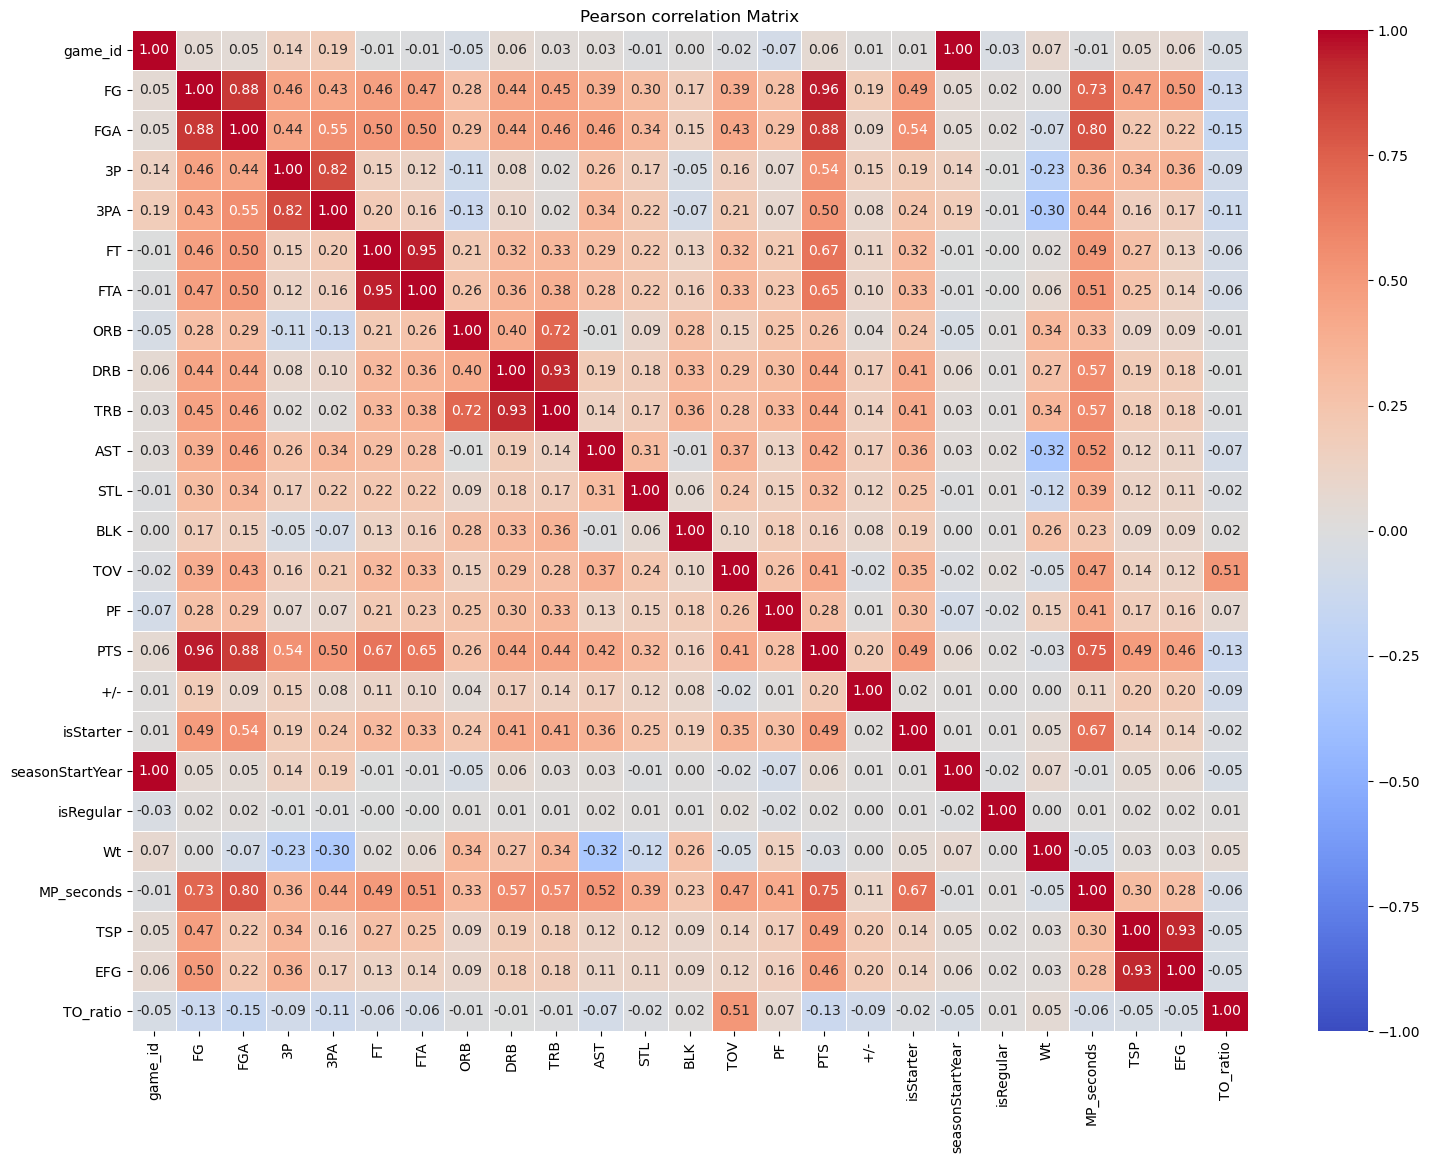

In [46]:
#PEARSON CORRELATION

plt.figure(figsize=(18, 13)) 
# Plot the heatmap
sns.heatmap(correlation_pearson, annot=True, vmin=-1, vmax=1, cmap="coolwarm", fmt=".2f", linewidths=.5,
            xticklabels=correlation_pearson.columns, yticklabels=correlation_pearson.columns)

plt.title("Pearson correlation Matrix")
plt.show()


In [47]:
#SPEARMAN CORRELATION
spearmanCorr = Correlation.corr(assembled_df, 'features', 'spearman').collect()[0][0]

#trasformo la DenseMatrix in un array numpy
correlation_array = spearmanCorr.toArray() #ritorna un numpy.ndarray

correlation_spearman = pd.DataFrame(
    correlation_array,
    index = features,
    columns = features
)

correlation_spearman

23/12/04 14:32:11 WARN Executor: Managed memory leak detected; size = 165892722 bytes, task 0.0 in stage 205.0 (TID 157)
23/12/04 14:34:34 WARN Executor: Managed memory leak detected; size = 165892722 bytes, task 0.0 in stage 211.0 (TID 159)


,game_id,FG,FGA,3P,3PA,FT,FTA,ORB,DRB,TRB,...,PTS,+/-,isStarter,seasonStartYear,isRegular,Wt,MP_seconds,TSP,EFG,TO_ratio
game_id,1.000000,0.054623,0.049310,0.154124,0.197556,-0.011156,-0.017162,-0.056997,0.060124,0.025603,...,0.057465,0.009436,0.008143,0.998851,-0.034958,0.069870,-0.005352,0.056553,0.067423,-0.043248
FG,0.054623,1.000000,0.886828,0.447979,0.405528,0.475301,0.482684,0.312526,0.491052,0.509632,...,0.966445,0.180989,0.499955,0.054302,0.030707,-0.011075,0.764171,0.572706,0.615069,0.051605
FGA,0.049310,0.886828,1.000000,0.442368,0.530965,0.501810,0.502077,0.316064,0.501739,0.520947,...,0.885631,0.090089,0.556523,0.049205,0.029529,-0.083530,0.832547,0.239586,0.270190,0.043720
3P,0.154124,0.447979,0.442368,1.000000,0.792886,0.154269,0.130928,-0.106463,0.114262,0.054219,...,0.506240,0.130171,0.191270,0.153572,-0.005719,-0.279049,0.376825,0.369462,0.393742,-0.011801
3PA,0.197556,0.405528,0.530965,0.792886,1.000000,0.182931,0.153116,-0.137352,0.116882,0.044570,...,0.458771,0.063737,0.223172,0.197096,-0.009898,-0.381848,0.435726,0.146220,0.166344,-0.011993
FT,-0.011156,0.475301,0.501810,0.154269,0.182931,1.000000,0.951601,0.242003,0.357530,0.376488,...,0.645164,0.110274,0.328889,-0.011165,0.007209,0.022387,0.526432,0.343587,0.168018,0.062126
FTA,-0.017162,0.482684,0.502077,0.130928,0.153116,0.951601,1.000000,0.275165,0.379388,0.406476,...,0.636864,0.102075,0.336990,-0.017059,0.007626,0.054182,0.533814,0.312980,0.177551,0.067651
ORB,-0.056997,0.312526,0.316064,-0.106463,-0.137352,0.242003,0.275165,1.000000,0.388711,0.678750,...,0.301463,0.038762,0.249018,-0.056820,0.015734,0.344652,0.337493,0.104382,0.111348,0.077285
DRB,0.060124,0.491052,0.501739,0.114262,0.116882,0.357530,0.379388,0.388711,1.000000,0.926869,...,0.499755,0.161884,0.428833,0.060024,0.016351,0.258507,0.607495,0.216792,0.219540,0.133693
TRB,0.025603,0.509632,0.520947,0.054219,0.044570,0.376488,0.406476,0.678750,0.926869,1.000000,...,0.512587,0.141773,0.433888,0.025576,0.018356,0.337190,0.609510,0.211642,0.216523,0.135054


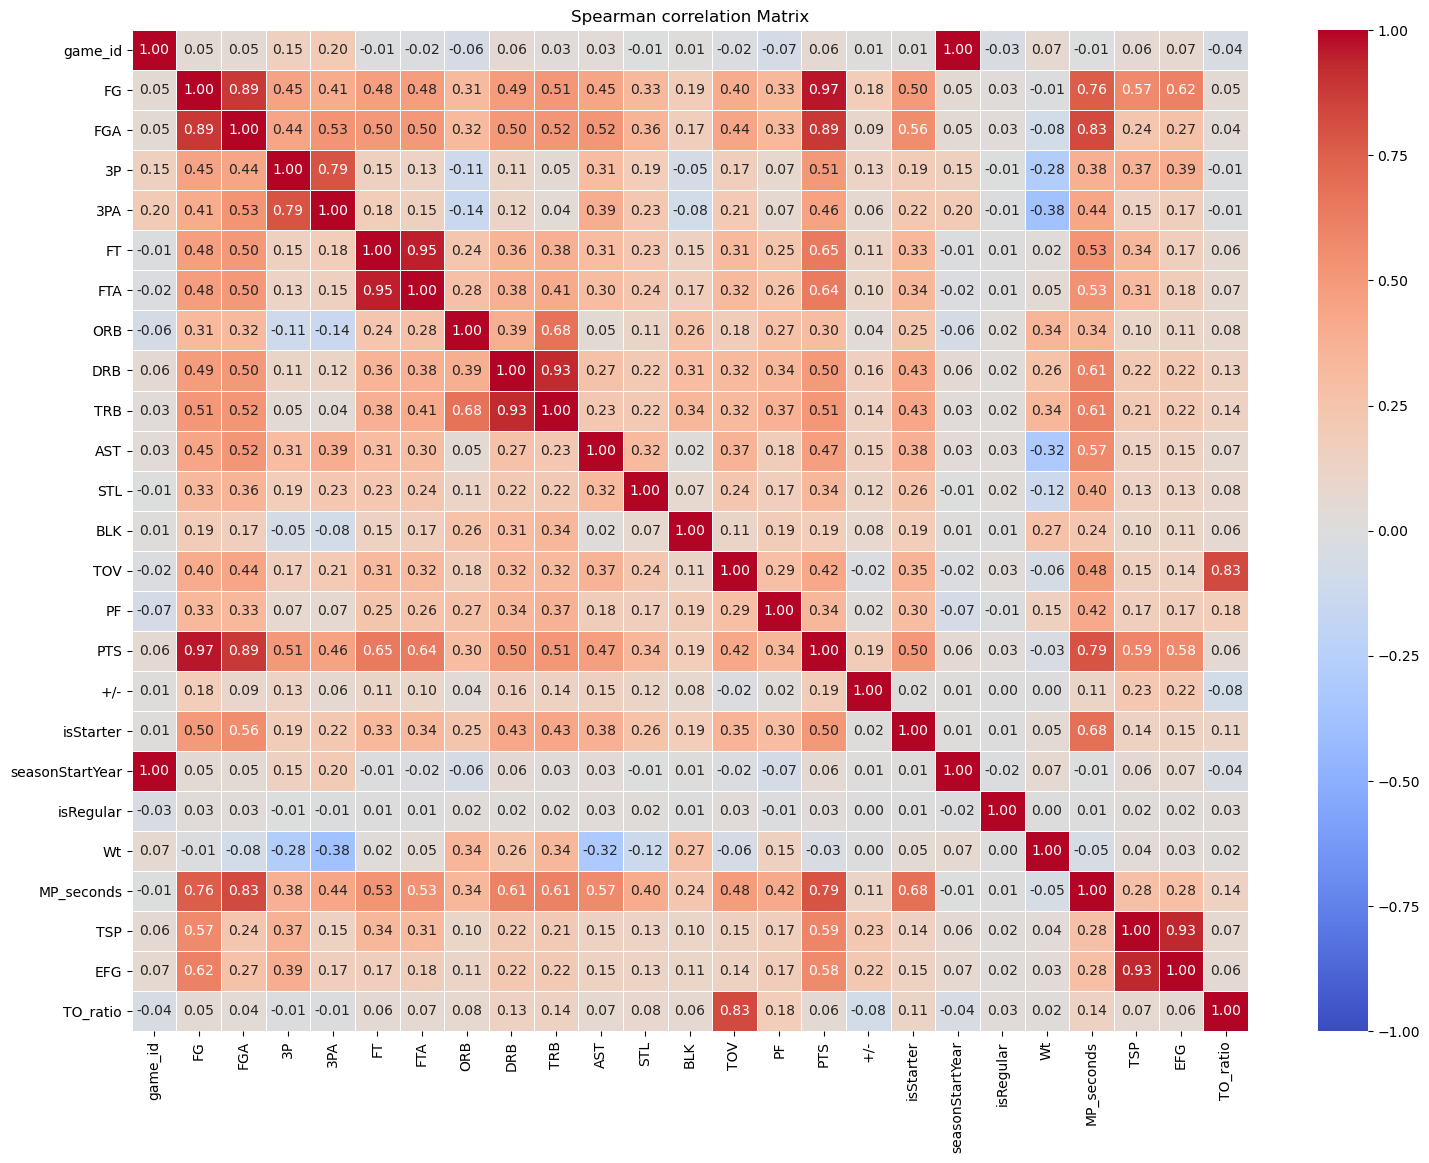

In [48]:
#SPEARMAN CORRELATION
plt.figure(figsize=(18, 13)) 
# Plot the heatmap
sns.heatmap(correlation_spearman, annot=True, vmin=-1, vmax=1, cmap="coolwarm", fmt=".2f", linewidths=.5,
            xticklabels=correlation_spearman.columns, yticklabels=correlation_spearman.columns)

plt.title("Spearman correlation Matrix")
plt.show()

In [49]:
# Threshold for correlation (90%)
threshold = 0.90

# Identify columns with correlation higher than the threshold
highly_correlated_columns = []
seen=[]
for col in correlation_pearson.columns:
    correlated_cols = [c for c in correlation_pearson.columns if c != col and c not in seen and abs(correlation_pearson[col][c]) > threshold]
    if correlated_cols:
        highly_correlated_columns.append((col, correlated_cols))
        seen.append(col)
        seen.append(correlated_cols)

# Display the result
for col, correlated_cols in highly_correlated_columns:
    print(f"Column '{col}' is highly correlated with columns: {', '.join(correlated_cols)}")

Column 'game_id' is highly correlated with columns: seasonStartYear
Column 'FG' is highly correlated with columns: PTS
Column 'FT' is highly correlated with columns: FTA
Column 'DRB' is highly correlated with columns: TRB
Column 'TSP' is highly correlated with columns: EFG


In [50]:
# Threshold for correlation (90%)
threshold = 0.90

# Identify columns with correlation higher than the threshold
highly_correlated_columns = []
seen=[]
for col in correlation_spearman.columns:
    correlated_cols = [c for c in correlation_spearman.columns if c != col and c not in seen and abs(correlation_spearman[col][c]) > threshold]
    if correlated_cols:
        highly_correlated_columns.append((col, correlated_cols))
        seen.append(col)
        seen.append(correlated_cols)

# Display the result
columns_to_remove=[]
for col, correlated_cols in highly_correlated_columns[1:]:#from 1 since game_id is not interesting
    columns_to_remove.append(col)
    print(f"Column '{col}' is highly correlated with columns: {', '.join(correlated_cols)}")

Column 'FG' is highly correlated with columns: PTS
Column 'FT' is highly correlated with columns: FTA
Column 'DRB' is highly correlated with columns: TRB
Column 'TSP' is highly correlated with columns: EFG


In [3]:
df_boxscore = df_boxscore.drop(*columns_to_remove)

NameError: name 'df_boxscore' is not defined

# writing for better sharing

In [52]:
#writing csv for the sharing via github
output_path = "data/df_boxscore_all_years"
df_boxscore.write.csv(output_path, header=True, mode="overwrite")



# PLOTS

In [76]:
#!pip install  pyspark_dist_explore
import matplotlib.pyplot as plt
from pyspark_dist_explore import hist, distplot
import seaborn as sns


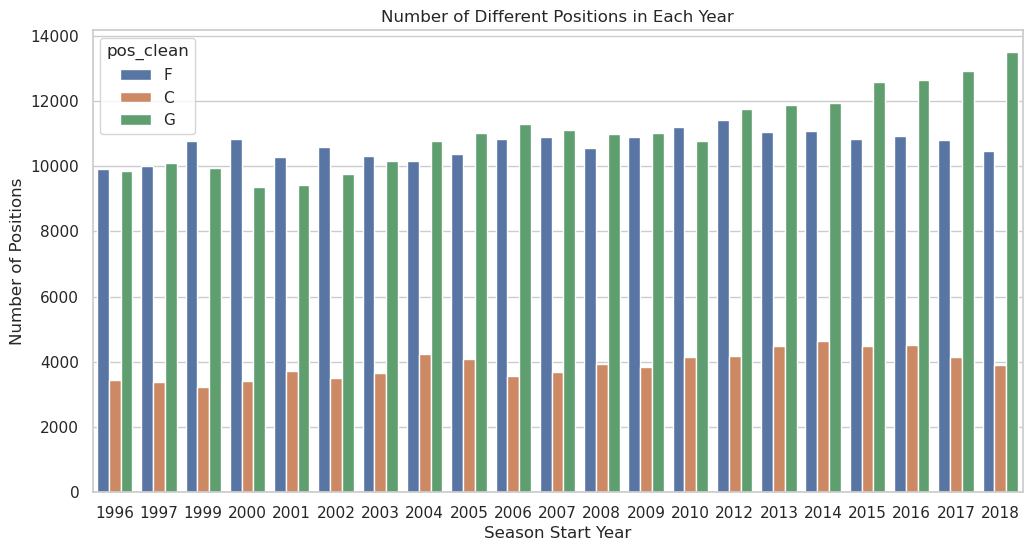

In [75]:
# Group by seasonStartYear and count the occurrences of each position
season_stats = df_boxscore.groupBy('seasonStartYear', 'pos_clean').agg({'pos_clean': 'count'})

# Rename the count column to a meaningful name
season_stats = season_stats.withColumnRenamed('count(pos_clean)', 'position_count')

aggregated_stats = season_stats.toPandas()

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Barplot
sns.barplot(x='seasonStartYear', y='position_count', hue='pos_clean', data=aggregated_stats)

plt.xlabel('Season Start Year')
plt.ylabel('Number of Positions')
plt.title('Number of Different Positions in Each Year')

# Show the plot
plt.show()

<Axes: xlabel='seasonStartYear'>

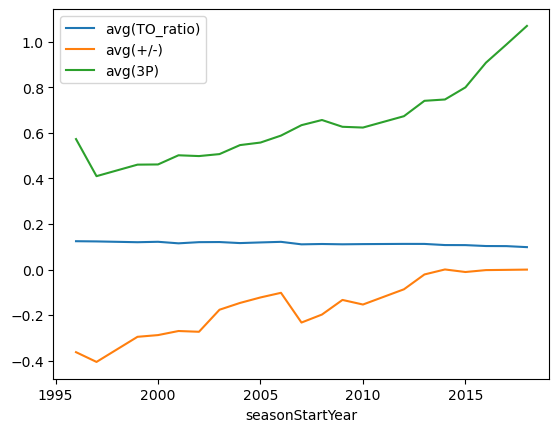

In [45]:
stats = df_boxscore.groupBy('seasonStartYear').agg({'3P':'mean', 'TO_ratio':'mean', '+/-':'mean'})
aggregated_stats = stats.toPandas()
aggregated_stats.sort_values(by='seasonStartYear').set_index('seasonStartYear').plot()

<Axes: xlabel='ORB', ylabel='+/-'>

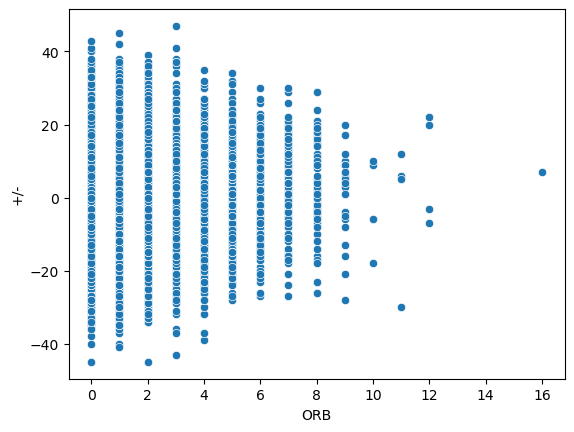

In [54]:
df_sampled = df_boxscore.sample(withReplacement = False, fraction = 0.05, seed=1)
sns.scatterplot(data=df_sampled.toPandas(), x="ORB", y="+/-")

<Axes: xlabel='+/-', ylabel='count'>

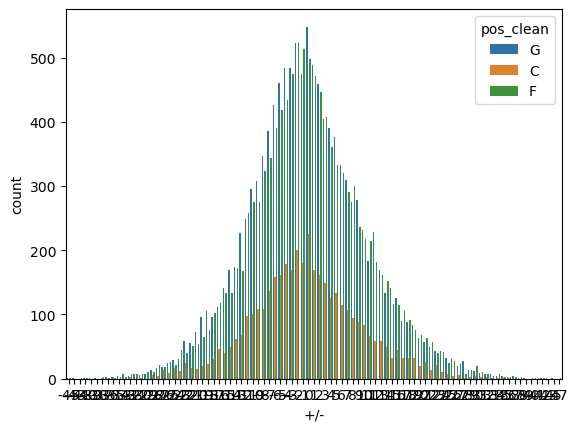

In [58]:
sns.countplot(data=df_sampled.toPandas(), x= '+/-',hue='pos_clean')


<Axes: xlabel='+/-', ylabel='ORB'>

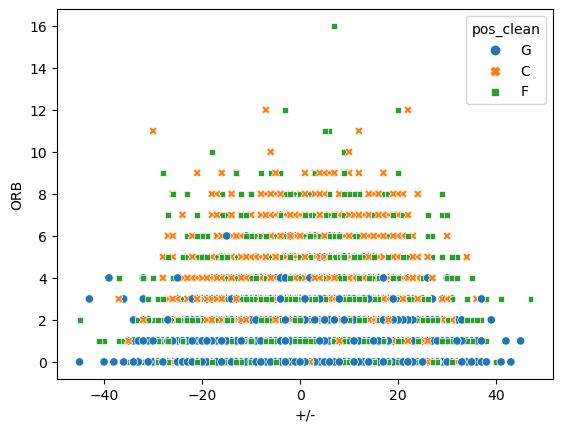

In [62]:
sns.scatterplot(data=df_sampled.toPandas(), x="+/-", y="ORB", hue="pos_clean", style="pos_clean")

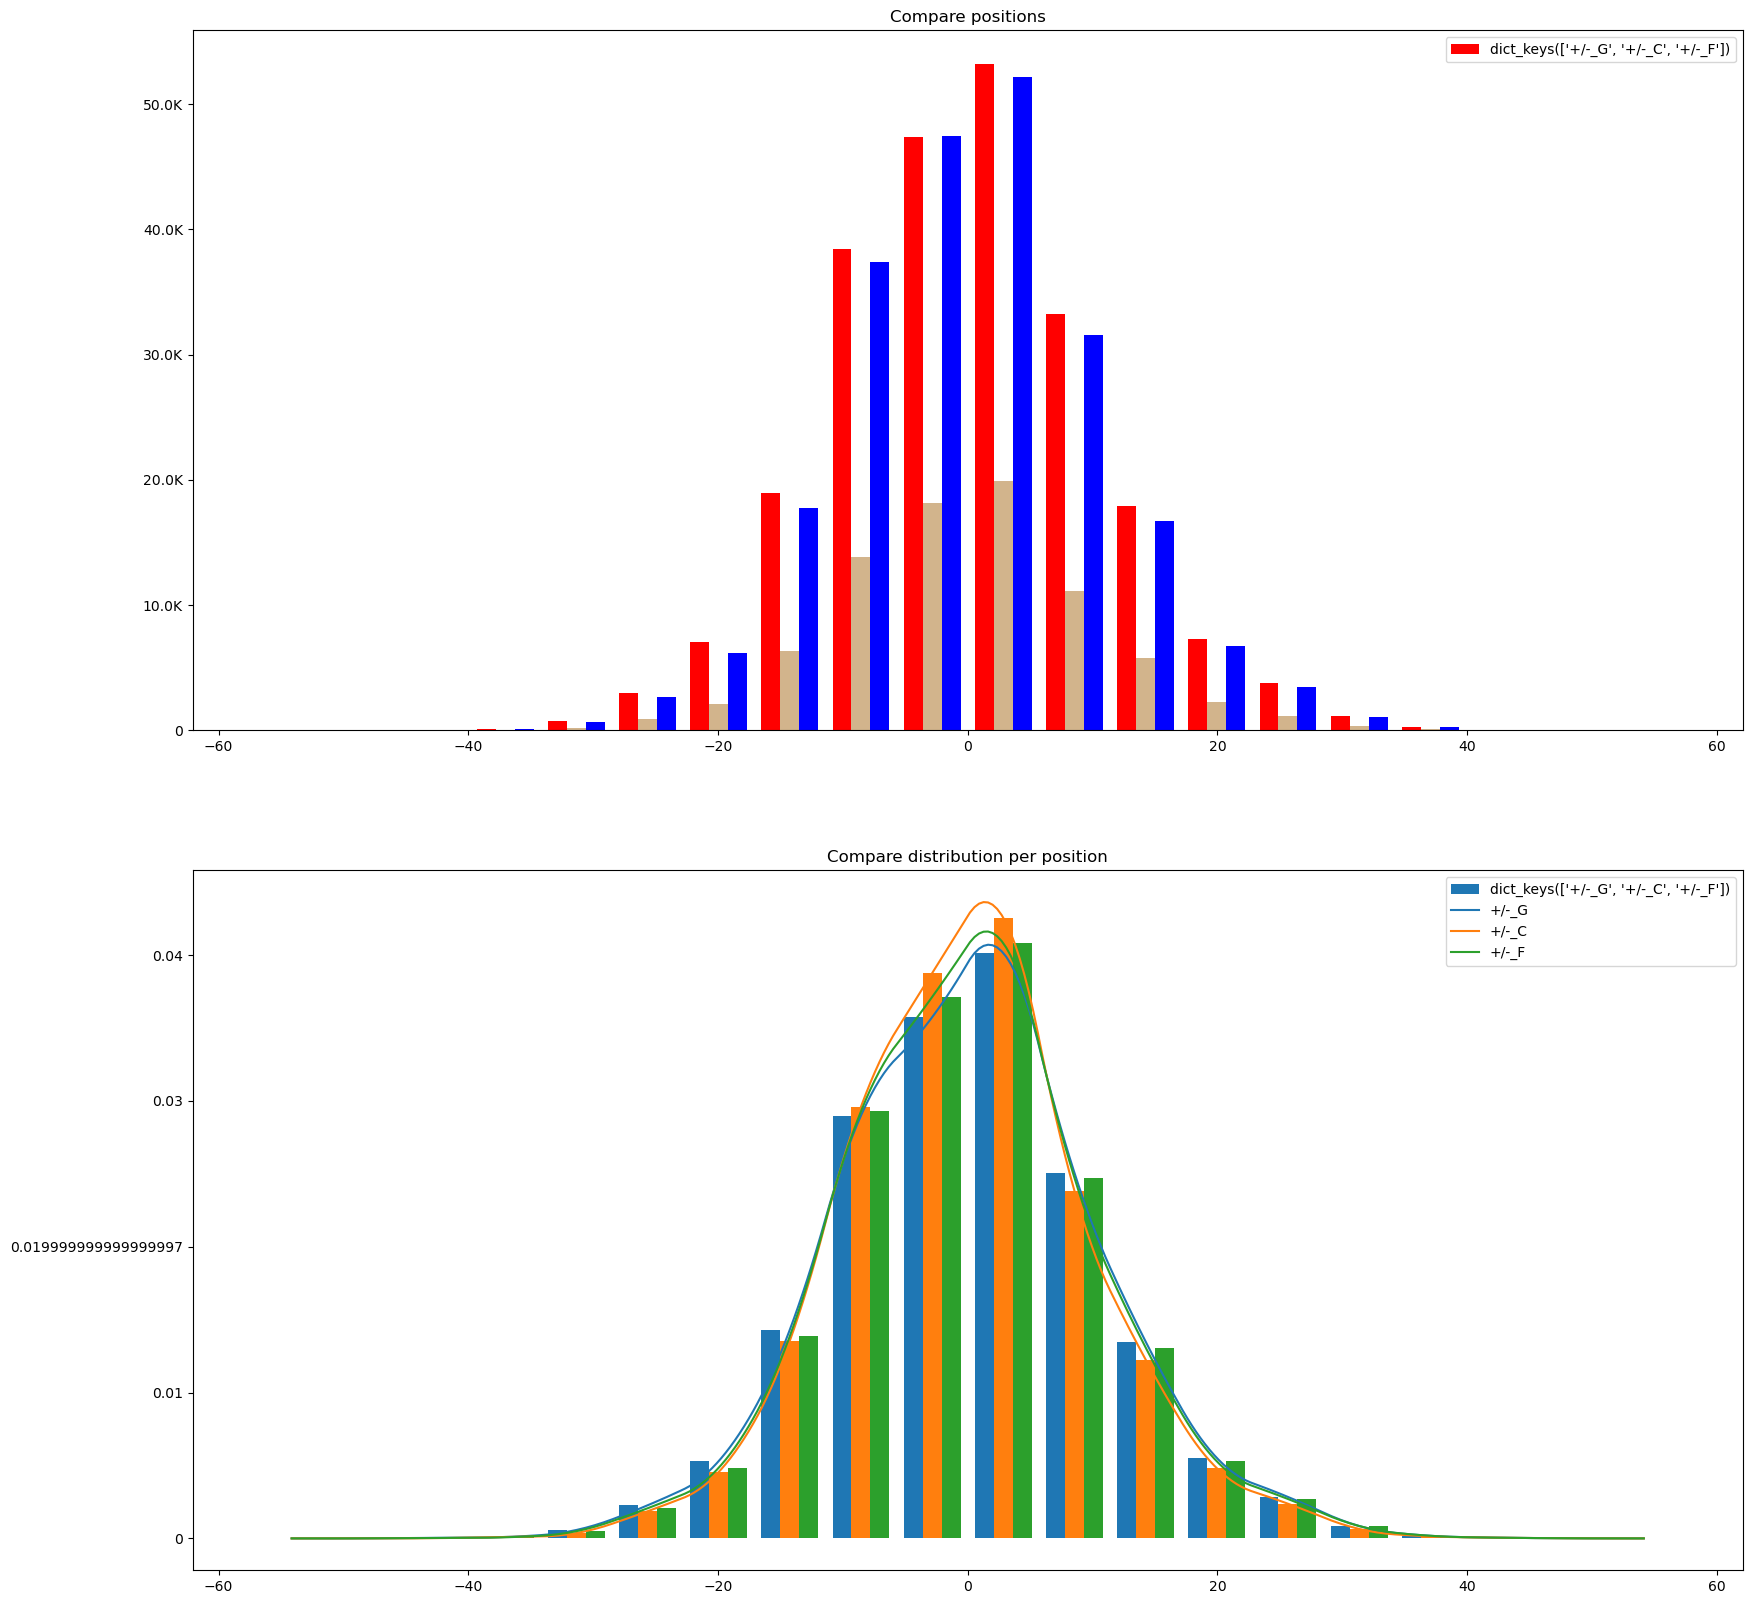

In [72]:
import pyspark.sql.functions as F
# Create some selections on this data

filtered_by_pos_G = df_boxscore.filter(F.col('pos_clean') == 'G').select(F.col('+/-').alias('+/-_G'))
filtered_by_pos_C = df_boxscore.filter(F.col('pos_clean') == 'C').select(F.col('+/-').alias('+/-_C') )                                                                            
filtered_by_pos_F = df_boxscore.filter(F.col('pos_clean') == 'F').select(F.col('+/-').alias('+/-_F'))
                                                                             
                                                                             
# Create the plots
    
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(20, 20)

# Use the hist function to plot histograms on the Axes
hist(axes[0], [filtered_by_pos_G, filtered_by_pos_C, filtered_by_pos_F], bins = 20, color=['red', 'tan', 'blue'])
axes[0].set_title('Compare positions')
axes[0].legend()

# Use the distplot function to plot (scaled) histograms + density plots on the Axes
distplot(axes[1], [filtered_by_pos_G, filtered_by_pos_C, filtered_by_pos_F], bins=20)
axes[1].set_title('Compare distribution per position')
axes[1].legend()

